Before we continue where we left off last week (fine tuning a pre-existing model) I want to give some background on image tasks in deep learning. 

Last weeks model was of a different type but today we will be looking at a fundamental deep learning model which is used in a hand written 
character recognition. You may have heard of the MNIST data set and this is what we will train our model on.

# So what is a Convolutional Neural Network (CNN)?
They are a type of neural network which are useful for processing grid like data. They do so by making use of the Convolution operation.
My way of thinking of the convolution is as reducing noise in the input (in an image we reduce noise and focus on what matters). 

## CNNs have three important properties
- Sparse connectivity
- Parameter sharing
- Equivariant representations

A CNN differs from a standard NN by way of this convolution, a typical NN has fully connected layers which use a matrix multiplication which 
means each input is connected to the output in the next layer along with a seperate parametet (WX + b). Essentially this means that every 
input unit interacts with the output units. However CNNs have <b>sparse connectivity</b>, this is accomplished by the kernel smaller than 
the input. For example, when processing an image it may have millions of pixels, but we can identify small meaningful features such as edges 
in small regions of thousands of pixels. This increases efficiency too, we store fewer parameters and computationally we have less
operations to perform. 

<b>Parameter sharing</b> is a property which arises from the nature of the convolution. In a typical NN, each parameter is only used once
when computing the output of a layer, its multiplied by one element of the input and never revisited. But in a CNN, the parameters are shared
across inputs. This is becuase of the nature of the kernel (filter) and it is applied across all the input data. This property means instead
of learning a bunch of different parameters we learn only one much smaller set of params. 

Lastly, due to parameter sharing we get the final property <b>equivariance to translation</b>. Translation means shifting the input and 
equivariance means any change in the input is the same in the output. This is kind of a confusing property so dont worry if its not too
clear as of yet. An example in image processing: convolution creates a 2D feature map where certain features appear in the input. If we move
the input by a small amount, its representation will move in the output the same amount. So in practise this means that the network will be
able to detect feature no matter where they are in the image, e.g if it detects a cats ear in the bottom left of the image it will also
be able to detect it in the top right (so long as scale and rotation has not changed).

## Pooling - the second key topic in CNNs
Pooling is a type of operation which modifies the output of the feature map. It is very simple, it replaces an area of the feature map with
a summary statistic of its neighbours (e.g. max of 2x2 area or avg of 3x3 area etc). The aim of pooling is to help make the input invariant
to small translations of the input, this is becuase if we translate the input a small amount the values of most of the pooled outputs
do not change.

[Further reading on Convolutional Neural Nets](https://www.deeplearningbook.org/contents/convnets.html)

# Lets take a look at that in pratice!
We will be working on implementing LeNet5 which was created by Yann Lecunn (a pioneer in computer vision) and we will implement the model 
and train it using PyTorch (which is way easier to download that TensorFlow xD)!

LeNet is a very early (1998!!!) deep learning model and one of the first to make use of CNNs. Despite its age the technology is still used
in models today and offers a great insight into how CNNs work and how we can create one ourselves.

To continue please get the paper [Gradient Based Learning Applied to Do cument Recognition](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). Here is the model architecure in all it's glory:
![LeNet5](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)

It employs a variety of techniques to establish it's goal - classifying hand written digits. We will train and test the model
using the MNIST dataset. So lets get started!

In [32]:
# We start off by importing the neccessary libraries
import torch
import torchvision

import torch.nn as nn

import torchvision.transforms as transforms

import os

In [33]:
data_path = os.getcwd() + '/Data'
data_path

'/Users/moose/Documents/PyCharm_Projects/Karpathy_NN_course/Lessons/Data'

In [34]:
# We can also set whether we want to use the GPU if present
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
	# If this prints dont worry we can do all the training here on a CPU :)
    print ("GPU not found.")

tensor([1.], device='mps:0')


# Loading the dataset

Next we load the MNIST dataset using PyTorch. The DataLoader is used by the neural net we create later.

A word here on how deep learning models are trained. When training a model we can decide the batch size, a batch being the data passed
to the model in one training run.

You can think of the proccess as:

Input data -> passed through network -> output and calculate a loss -> then perform back propagation whereby we calculate the derivative
of each layer w.r.t to the output layer -> update parameters to decrease loss

Where batches come in is with the gradient updating. If we pass one example at a time we may update the parameters too much, resulting
in poor performance from our model (due to getting stuck in local minima among other reasons). So we can pass data in batches and compute
gradient using the average loss of this batch (the output of a batch training run is a loss for each example within the batch).

We use a batch size of 64, this is not a special number really, batch size selection is empirical and its best to see that works (note
a smaller batch size will mean training takes longer).

We also transform the data as was stated by LeCun in the paper. The main transform is normalising the images and this accelerates learning. 

In [35]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,)),
])

# Root is the directory to which you will download the data, adjust it as necessary
mnist_train = torchvision.datasets.MNIST(
	root=data_path,
	train=True,
	download=True,
	transform=transform,
)

train_dataloader = torch.utils.data.DataLoader(
	mnist_train, 
	shuffle=True,
	batch_size=64,
)

mnist_test = torchvision.datasets.MNIST(
	root=data_path,
	train=False,
	download=True,
	transform=transform
)

test_dataloader = torch.utils.data.DataLoader(
	mnist_test,
	shuffle=True,
	batch_size=64,
)

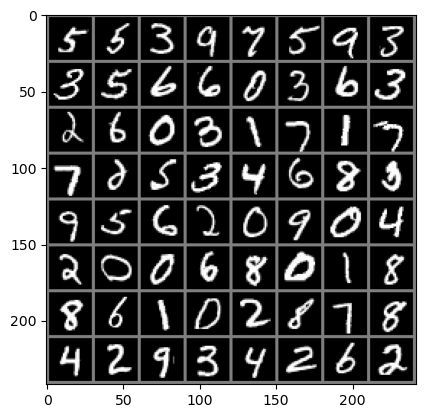

In [10]:
# Let's show some of the training images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

A bit about the MNIST dataset:

It is a collection of handwritten digits. The images are grayscale so the data is 2D (A coloured image is 3D to encode info on RGB colours),
they have a 28x28 size (this is important as our network required a 32x32 input, how will we get around this?). Below we print the size of
the train and test set respectively.

In [12]:
len(mnist_train), len(mnist_test)

(60000, 10000)

# Now lets go over the actual network architecture!

First let me cover some key terminology related to CNNs

Kernel - the actual filter which the model uses on the images. We often create multiple filters, which are initialised with different weights
and they each pass over all parts of the image and due to their different initial weights locate different features in the input.

Padding - Exactly what it says in the name we can add a border of 0 pixels with padding

Stride - For pooling, it determines at what points the summary statistic is taken. E.g. a stride of two will move the filter two pixels 
vertically/horizontally when taking filters.

So the first layer is a convolutional layer with 6 filters, this means we create 6 filters and apply them across the image. In this layer
we must add a padding of 2 to make the input image size 32x32. 

In [18]:
class LeNet5(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# Layer 1 is a convolutional layer with 6 filters and a 5x5 size
		# MNIST contains grey scale images, so we only have 1 input channels
		self.conv1 = nn.Conv2d(
			in_channels=1, 
			out_channels=6,
			kernel_size=(5, 5),
			padding=2,  # Add a padding of 2 0 pixles around the border (MNIST images are 28x28 and model input is 32x32)
		)
		# Layer 2 is a 2x2 average pooling, which takes avg over four inputs (stride=2)
		# (experiment with max pooling) and is also passed through a sigmoid
		self.avg_pool1 = nn.AvgPool2d(
			kernel_size=(2, 2),
			stride=(2, 2),
		)
		self.sig1 = nn.Sigmoid()
		
		# Layer 3 sees us connecting different parts of the feature maps from layer 2
		# To implement this I initialise 15 different convolutions with each having an output dimension of 1
		# I used name convetion conv2_[num in]_[C3 feature map number]
		# 3 inputs
		self.conv2_3_0 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_4 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_5 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		# 4 inputs
		self.conv2_4_6 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_7 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_8 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_9 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_10 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_11 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_12 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_13 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_14 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		# 6 inputs
		self.conv2_6_15 = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=(5,5))
		
		# Layer 4 is another subsampling layer with 2x2 average pooling
		self.avg_pool2 = nn.AvgPool2d(
			kernel_size=(2, 2),
			stride=(2, 2),
		)
		
		# Layer 5 is a convolutionallayer with 120 feature maps and a 5x5 convoltuion
		# This results in a height and width of 1 for each feature map
		self.conv3 = nn.Conv2d(
			in_channels=16,
			out_channels=120,
			kernel_size=(5, 5)
		)
		
		# Layer 6 if a fully connected (Linear layer) which computers y = xA + b (the dot product between input vector and the weight vector
		# and adds a bias) 
		# It is also passed through an activation (squashing) function in this case we use tanh
		self.linear1 = nn.Linear(120, 84)
		self.tanh1 = nn.Tanh()
		
		# Output layer is supposed to use Euclidean Radial Basic Function units but I use softmax (TODO: implement RBF)
		# I first pass F6 through a fully connected layer to get 10 length vector
		self.linear2 = nn.Linear(84, 10)
		#self.softmax1 = nn.Softmax()
		
	def forward(self, x):
		# C1 - 5x5 convolution - output is 6, 28x28 filters
		x = self.conv1(x)
		#print(f'Shape after C1: {x.shape}')
		# S2 - 2x2 avg pooling, which is passed through a sigmoid - output is 6 14x14 filters
		x = self.avg_pool1(x)
		x = self.sig1(x)
		#print(f'Shape after S2: {x.shape}')
		# C3 - 5x5 convolution but we must engineer the connections from the previous layer
		# feature map 0-5 in C3 are connected to 3 contiguous feature maps from S2 (e.g. 0-2, 1-3, 2-4 etc.)
		# feature map 6 - 11 are connected in the same way but to 4 contiguous feature maps
		# feature map 12 - 14 are the same but discontiguous 4 feature maps
		# feature map 15 is all 6 maps from S2
		map_ranges = [
			# Length 3 maps 0-5
			(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 0), (5, 0, 1),
			# Length 4 maps 6-11
			(0, 1, 2, 3), (1, 2, 3, 4), (2, 3, 4, 5), (3, 4, 5, 0), (4, 5, 0, 1), (5, 0, 1, 2),
			# Length 4 maps discontiguous 12-14
			(0, 1, 3, 4), (1, 2, 4, 5), (0, 2, 3, 5),
			# All maps 15
			(0, 1, 2, 3, 4, 5),
		]
		# We assume tensor dimensions are (batch_size, channels, width, length) and apply each map to the specific conv layer defined in init
		c3_maps = []
		c3_maps.append(self.conv2_3_0(x[:, map_ranges[0], :, :]))
		c3_maps.append(self.conv2_3_1(x[:, map_ranges[1], :, :]))
		c3_maps.append(self.conv2_3_2(x[:, map_ranges[2], :, :]))
		c3_maps.append(self.conv2_3_3(x[:, map_ranges[3], :, :]))
		c3_maps.append(self.conv2_3_4(x[:, map_ranges[4], :, :]))
		c3_maps.append(self.conv2_3_5(x[:, map_ranges[5], :, :]))
		
		c3_maps.append(self.conv2_4_6(x[:, map_ranges[6], :, :]))
		c3_maps.append(self.conv2_4_7(x[:, map_ranges[7], :, :]))
		c3_maps.append(self.conv2_4_8(x[:, map_ranges[8], :, :]))
		c3_maps.append(self.conv2_4_9(x[:, map_ranges[9], :, :]))
		c3_maps.append(self.conv2_4_10(x[:, map_ranges[10], :, :]))
		c3_maps.append(self.conv2_4_11(x[:, map_ranges[11], :, :]))
		c3_maps.append(self.conv2_4_12(x[:, map_ranges[12], :, :]))
		c3_maps.append(self.conv2_4_13(x[:, map_ranges[13], :, :]))
		c3_maps.append(self.conv2_4_14(x[:, map_ranges[14], :, :]))
		
		c3_maps.append(self.conv2_6_15(x[:, map_ranges[15], :, :]))
			
		# To complete C3 we concatenate all 16 convolutional layers which produces a tensor of 16 layers together
		x = torch.cat(c3_maps, dim=1)
		#print(f'Shape after C3: {x.shape}')
		
		# S4 is another subsampling layer (not sure if I need to add sigmoid here?)
		x = self.avg_pool2(x)
		#print(f'Shape after S4: {x.shape}')
		
		# C5 is a 5x5 convolution with 120 filters, this flattens the input from S4 as we end up with a 1x1 2-d matrix
		x = self.conv3(x)
		#print(f'Shape after C5: {x.shape}')
	
		# Before passing to the fully connected layer we must flatten the tensor as nn.Linear expects a vecotr (1d input)
		x = torch.flatten(x, start_dim=1)
		# F6 is a fully connected layer which is passed through a tanh
		x = self.linear1(x)
		x = self.tanh1(x)
		#print(f'Shape after F6: {x.shape}')
		
		# We first create another fully connected layer and then pass the output through a softmax.
		# The softmax converts the logits to probabilites (sum to 1)
		# The output layer uses softmax to output 10 probabilites for each class (0-9 digits)
		x = self.linear2(x)
		# x = self.softmax1(x) if using cross entropy loss don't apply softmax
		#print(f'Shape at output: {x.shape}')
		
		return x

net = LeNet5()

if torch.backends.mps.is_available():
	net.to(device)
elif torch.backends.cuda.is_built():
	net.to(device)
else:
	print('Running on CPU')

In [19]:
# Defining the optimizer and loss function
# We use cross entropy loss and basic stochastic gradient descent to train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

# Now for the fun part - Training
Now for the training. We run the model for 20 epochs, which is becuase that is what is laid out in the paper.

The process goes like this

Load current batch, pass it to the network, calculate the loss and apply backpropagation w.r.t the loss, make a gradient step and then we
do it again

In [20]:
# Training the model
for epoch in range(20):
	running_loss = 0.0
	
	for i, data in enumerate(train_dataloader, 0):
		inputs, labels = data
		inputs, labels = inputs.to(device), labels.to(device)
		#labels = labels.to(torch.float32)
		optimizer.zero_grad()
		
		outputs = net(inputs)
		loss = criterion(outputs, labels)
		#print(loss.dtype, labels.dtype)
		loss.backward()
		optimizer.step()
		
		running_loss += loss.item()
	
	# Move this print statement outside the inner loop
	print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_dataloader):.3f}')
	running_loss = 0.0

print('Finished Training')

Epoch [1] loss: 1.068
Epoch [2] loss: 0.295
Epoch [3] loss: 0.226
Epoch [4] loss: 0.190
Epoch [5] loss: 0.167
Epoch [6] loss: 0.149
Epoch [7] loss: 0.137
Epoch [8] loss: 0.126
Epoch [9] loss: 0.117
Epoch [10] loss: 0.110
Epoch [11] loss: 0.103
Epoch [12] loss: 0.097
Epoch [13] loss: 0.093


KeyboardInterrupt: 

# Testing the model
Lets test the model we have created on the test set and with some visual inspection.

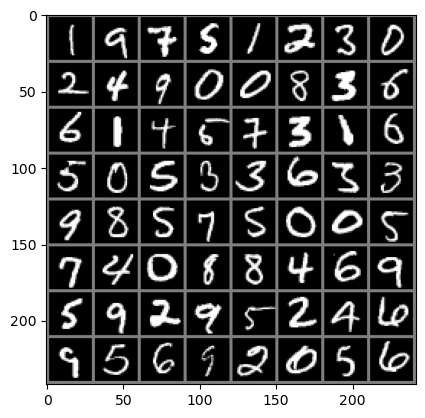

In [21]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))

# Push images to gpu
images, labels = images.to(device), labels.to(device)

In [22]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
predicted

tensor([1, 9, 7, 5, 1, 2, 3, 0, 2, 4, 9, 0, 0, 8, 3, 6, 6, 1, 9, 5, 7, 3, 1, 6,
        5, 0, 5, 3, 3, 6, 3, 3, 9, 8, 5, 7, 5, 0, 0, 5, 7, 4, 0, 8, 8, 4, 6, 9,
        5, 9, 2, 9, 5, 2, 4, 6, 9, 5, 6, 5, 0, 0, 5, 6], device='mps:0')

In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
	for data in test_dataloader:
		images, labels = data
		# Push images to gpu
		images, labels = images.to(device), labels.to(device)
		
		# calculate outputs by running images through the network
		outputs = net(images)
		# the class with the highest energy is what we choose as prediction
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %
